# Kanapy – Generation of voxelized RVE
Generate a representation volume element (RVE) for a synthetic microstructure and export geometry as Abaqus INP file. Generate orientation for each grain in form of Euler angles that are characteristic for a given crystallographic texture.


Author: Alexander Hartmaier, ICAMS / Ruhr-University Bochum, Germany<br>
May 2022

### 1. Create geometric representation of microstructure

Generating particle distribution based on user defined statistics


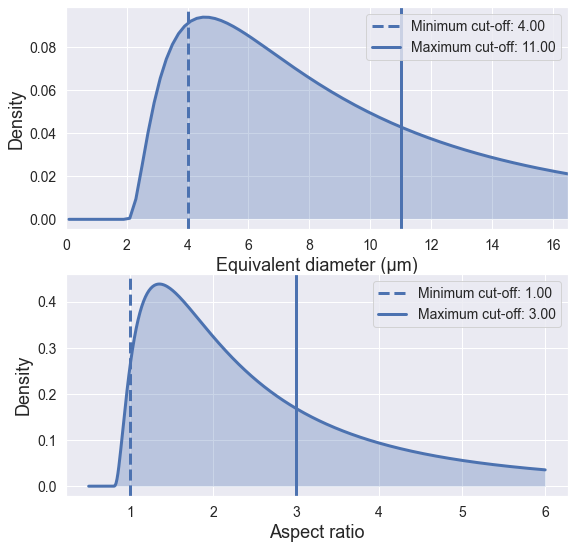

Creating an RVE based on user defined statistics
    Total number of grains        = 29
    RVE side lengths (X, Y, Z)    = 20, 20, 20
    Number of voxels (X, Y, Z)    = 15, 15, 15
    Voxel resolution (X, Y, Z)    = 1.3333, 1.3333, 1.3333
    Total number of voxels (C3D8) = 3375

Starting particle simulation
    Creating simulation box of required dimensions
    Creating particles from distribution statistics
    Particle packing by growth simulation


 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 701/1001 [01:11<00:30,  9.83it/s]


Completed particle packing
36 overlapping particles detected after packing
Kinetic energy of particles after packing: 4.945306492511118
Initial kinetic energy: 4.216803373055023



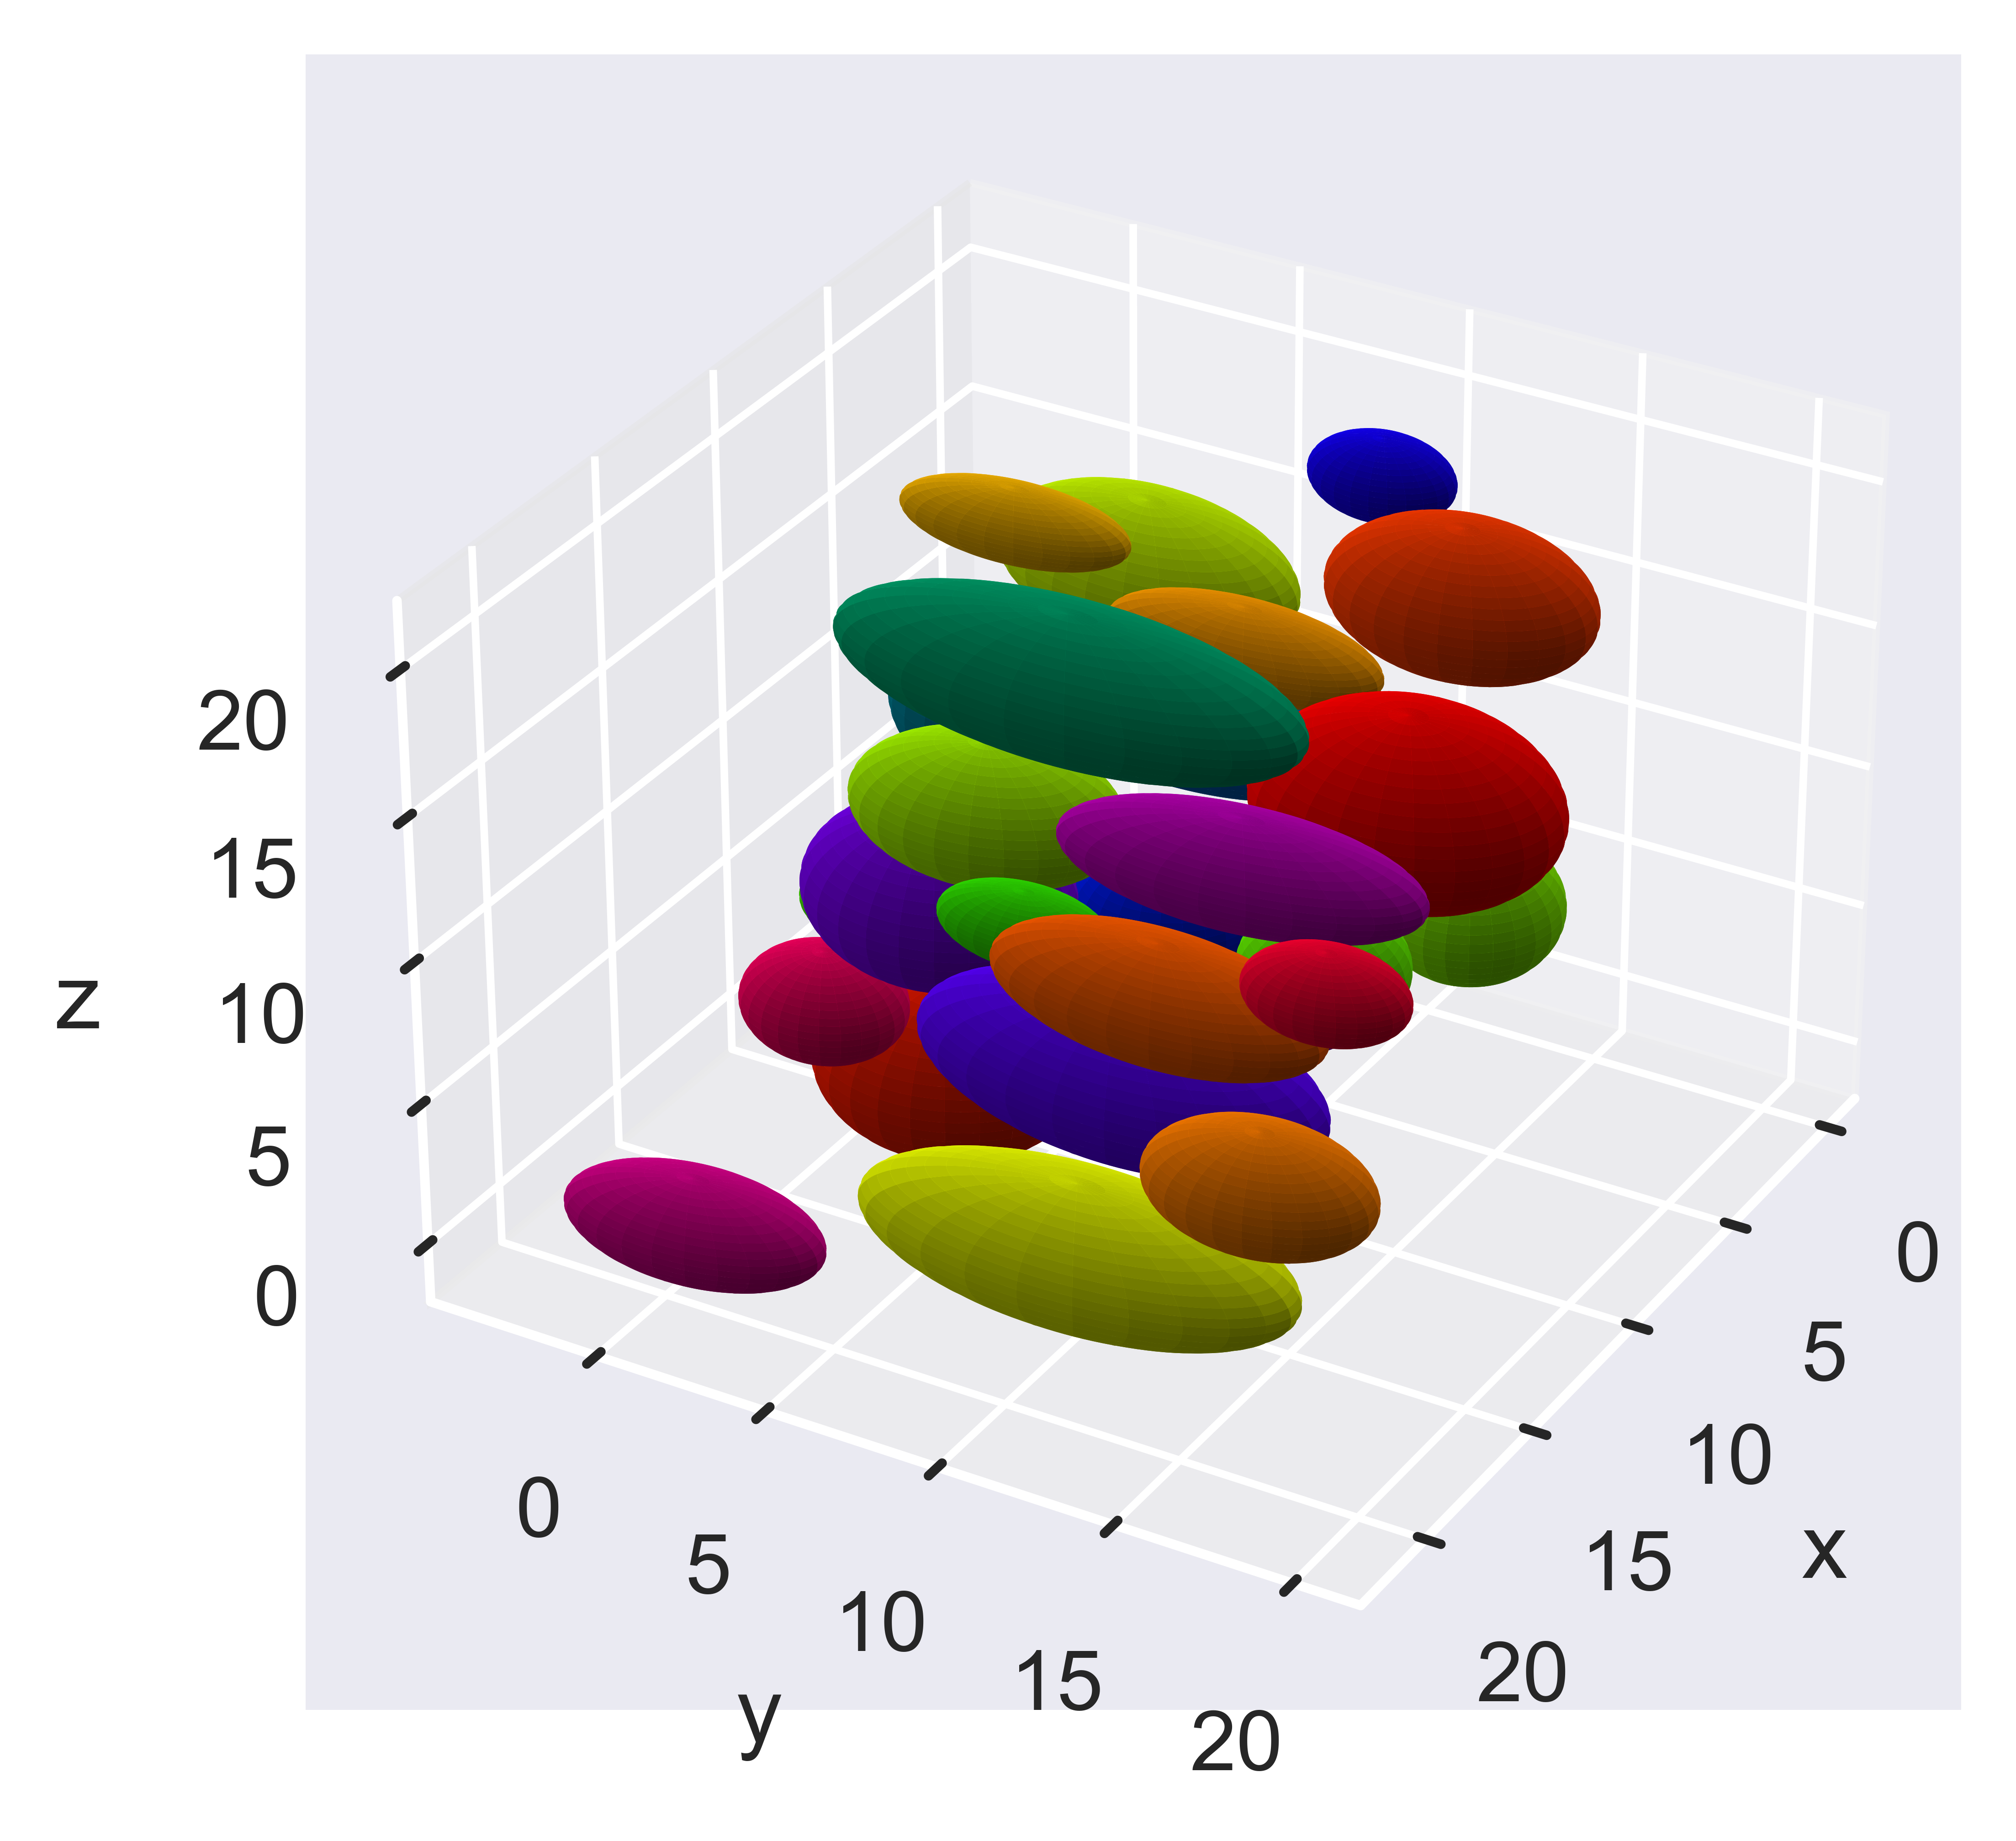


Starting RVE voxelization
    Generating voxels inside RVE
### create voxels 4096 (4096, 3)
    Assigning voxels to grains


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3375/3375 [00:00<00:00, 3184651.52it/s]


Completed RVE voxelization


Generated Delaunay tesselation of grain vertices.
Assigning 563 tetrahedra to grains ...


563it [00:03, 173.50it/s]


Finished generating polyhedral hulls for grains.
Mean absolute error of polyhedral vs. voxel volume of grains: 0.24711860440514608

Computing the L1-error between input and output diameter distributions
    L1 error between particle and grain geometries: 0.89655

Writing ABAQUS (.inp) file---->DONE!



'geom15_gr29_pbc.inp'

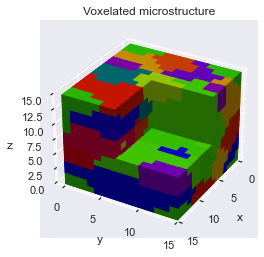

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import kanapy as knpy

# Basic material definitions
matname = 'Austenite fcc'
matnumber = 4  # UMAT number for fcc Iron

# RVE and microstructure paramaters
Nv = 15  # number of voxels
size = 20  # size of RVE
periodic = True
ms_elong = {'Grain type': 'Elongated',
          'Equivalent diameter': {'std': 1.0, 'mean': 7.0, 'offs': 2.0, 'cutoff_min': 4.0, 'cutoff_max': 11.0},
          'Aspect ratio': {'std':1.0, 'mean': 1.5, 'offs': 0.8, 'cutoff_min': 1.0, 'cutoff_max': 3.0},
          'Tilt angle': {'std': 2., 'mean': 90., "cutoff_min": 0.0, "cutoff_max": 180.0},
          'RVE': {'sideX': size, 'sideY':size, 'sideZ': size, 'Nx': Nv, 'Ny': Nv, 'Nz': Nv},
          'Simulation': {'periodicity': str(periodic), 'output_units': 'mm'},
          'Phase': {'Name': 'Austenite', 'Number': matnumber, 'Volume fraction': 1.0}}

ms = knpy.Microstructure(ms_elong)
ms.init_stats()
ms.init_RVE()
ms.pack()
ms.plot_ellipsoids()
ms.voxelize()
ms.plot_voxels()
ms.generate_grains()

# write Abaqus input file for voxelated geometry
ptag = 'pbc' if periodic else 'no_pbc'
ms.output_abq('v', name=f'geom{Nv}_gr{ms.Ngr}_{ptag}.inp')

### 2. Generate set of grain orientations for specified texture

In [3]:
texture = 'random' # Implemented textures are goss, copper, random
mdf = 'high'
if knpy.MTEX_AVAIL:
    # define standard parameters for misorientation distribution functions
    """Test cases for misorientation distribution (MDF) adapted from
    Miodownik, M., et al. "On boundary misorientation distribution functions
    and how to incorporate them into three-dimensional models of microstructural
    evolution." Acta materialia 47.9 (1999): 2661-2668.
    https://doi.org/10.1016/S1359-6454(99)00137-8
    """
    mdf_freq = {
      "high": [0.0013303016, 0.208758929, 0.3783092708, 0.7575794912, 1.6903069613,
               2.5798481069, 5.0380640643, 10.4289690569, 21.892113657, 21.0,
               22.1246762077, 13.9000439533],
      "low":  [4.5317, 18.6383, 25, 20.755, 12.5984, 7.2646, 4.2648, 3.0372, 2.5,
               1, 0.31, 0.1],
      "random": [0.1, 0.67, 1.9, 3.65, 5.8, 8.8, 11.5, 15.5, 20, 16.7, 11.18, 4.2]
    }
    mdf_bins = np.linspace(62.8/12,62.8,12)

    # generate grain orientations and write ang file
    """
    Different textures can be choosen and assinged to the RVE geometry that has
    been defined above.
    Texture is defined by the orientation of the ideal component in Euler space
    ang and a kernel halfwidth omega. Kernel used here is deLaValleePoussin.
    The function createOriset will first create an artificial EBSD by sampling
    a large number of discrete orientations from the ODF defined by ang and
    omega. Then a reduction method is applied to reconstruct this initial ODF
    with a smaller number of discrete orientations Ngr. The reduced set of
    orientations is returned by the function.
    For more information on the method see:
    https://doi.org/10.1107/S1600576719017138
    """
    if texture == 'random':
        #For Random texture, no subsampling and ODF recreation is neccessary
        ori_rve = knpy.createOrisetRandom(ms.Ngr)
    else:
        if texture == 'goss':
            ang = [0, 45, 0]    # Euler angle for Goss texture
            omega = 7.5         # kernel half-width
        elif texture == 'copper':
            ang = [90, 35, 45]
            omega = 7.5
        else:
            raise ValueError('texture not defined. Take goss, copper or random')
        ori_rve = knpy.createOriset(ms.Ngr, ang, omega, hist=mdf_freq[mdf],
                                    shared_area=ms.shared_area)

    # write Euler angles of grains into Abaqus input file
    knpy.writeAbaqusMat(matnumber, ori_rve)
    !mv Material.inp 'mat{matnumber}_gr{ms.Ngr}_tx-{texture[0:4]}.inp'

I found another version of MTEX and remove it from the current search path!
initialize MTEX 5.5.2  .... done!
 
 For compatibility reasons MTEX is not using OpenMP.
 You may want to switch on OpenMP in the file <a href="matlab: edit mtex_settings">mtex_settings.m</a>
 
mv: rename Material.inp to mat4_gr29_tx-rand.inp: No such file or directory
